# Forecaster with Deep Learning

## Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)

Recurrent Neural Networks (RNN) are a type of neural networks designed to process data that follows a sequential order. In conventional neural networks, such as feedforward networks, information flows in one direction, from input to output through hidden layers, without considering the sequential structure of the data. In contrast, RNNs maintain internal states or memories, which allow them to remember past information and use it to predict future data in the sequence.

The basic unit of an RNN is the recurrent cell. This cell takes two inputs: the current input and the previous hidden state. The hidden state can be understood as a "memory" that retains information from previous iterations. The current input and the previous hidden state are combined to calculate the current output and the new hidden state. This output is used as input for the next iteration, along with the next input in the data sequence.

Despite the advances that have been achieved with RNN architectures, they have limitations to capture long-term patterns. This is why variants such as  Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRU) have been developed, which address these problems and allow long-term information to be retained more effectively.

<p align="center"><img src='../img/schema-rnn-model.jpg'style="width: 600px"></p>


<center><font size='2.5'> <i>RNN diagram. Fuente: James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (1st ed.) [PDF]. Springer.</i></font></center>


Long Short-Term Memory (LSTM) neural networks are a specialized type of RNNs designed to overcome the limitations associated with capturing long-term temporal dependencies. Unlike traditional RNNs, LSTMs incorporate a more complex architecture, introducing memory units and gate mechanisms to improve information management over time.

**Structure of LSTMs**

LSTMs have a modular structure consisting of three fundamental gates: the forget gate, the input gate, and the output gate. These gates work together to regulate the flow of information through the memory unit, allowing for more precise control over what information to retain and what to forget.

+ **Forget Gate:** Regulates how much information should be forgotten and how much should be retained, combining the current input and the previous output through a sigmoid function.

+ **Input Gate:** Decides how much new information should be added to long-term memory.

+ **Output Gate:** Determines how much information from the current memory will be used for the final output, combining the current input and memory information through a sigmoid function.



<p align="center"><img src='https://databasecamp.de/wp-content/uploads/lstm-architecture-1024x709.png'style="width: 400px"></p>

<center><font size='2.5'> <i>Diagram of the inputs and outputs of an LSTM. Fuente: codificandobits https://databasecamp.de/wp-content/uploads/lstm-architecture-1024x709.png.</i></font></center>


<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about forecasting with deep learning  models visit our examples:

<ul>
    <li>
    <a href="https://www.cienciadedatos.net/documentos/py54-forecasting-with-deep-learning.html">Deep Learning for time series forecasting: Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)</a>.
    </li>
</ul>

</div>

## Libraries and data

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip: Configuring your backend</b>
</p>


As of Skforecast version <code>0.13.0</code>, PyTorch backend support is available. You can configure the backend by exporting the <code>KERAS_BACKEND</code> environment variable or by editing your local configuration file at <code>~/.keras/keras.json</code>. The available backend options are: "tensorflow" and "torch". Example:

```python
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
```

</div>

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

Note: The backend must be configured before importing Keras, and the backend cannot be changed after the package has been imported.

</div>

In [24]:
%load_ext autoreload
%autoreload 2
# Libraries
# ==============================================================================
import os
os.environ["KERAS_BACKEND"] = "torch"  # 'tensorflow', 'jax´ or 'torch'
import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import skforecast
from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset
from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning.utils import create_and_compile_model
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries

from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('once')

print(f"skforecast version: {skforecast.__version__}")
print(f"keras version: {keras.__version__}")

if keras.__version__ > "3.0":
    print(f"Using backend: {keras.backend.backend()}")
    if keras.backend.backend() == "tensorflow":
        import tensorflow
        print(f"tensorflow version: {tensorflow.__version__}")
    elif keras.backend.backend() == "torch":
        import torch
        print(f"torch version: {torch.__version__}")
    else:
        print("Backend not recognized. Please use 'tensorflow' or 'torch'.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
skforecast version: 0.15.0
keras version: 3.7.0
Using backend: torch
torch version: 2.5.1+cu124


In [25]:
# Data download
# ==============================================================================
air_quality = fetch_dataset(name="air_quality_valencia_no_missing")
air_quality.head()

air_quality_valencia_no_missing
-------------------------------
Hourly measures of several air chemical pollutant at Valencia city (Avd.
Francia) from 2019-01-01 to 20213-12-31. Including the following variables:
pm2.5 (µg/m³), CO (mg/m³), NO (µg/m³), NO2 (µg/m³), PM10 (µg/m³), NOx (µg/m³),
O3 (µg/m³), Veloc. (m/s), Direc. (degrees), SO2 (µg/m³). Missing values have
been imputed using linear interpolation.
Red de Vigilancia y Control de la Contaminación Atmosférica, 46250047-València -
Av. França, https://mediambient.gva.es/es/web/calidad-ambiental/datos-
historicos.
Shape of the dataset: (43824, 10)


,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5
datetime,,,,,,,,,,
2019-01-01 00:00:00,8.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,19.0
2019-01-01 01:00:00,8.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,26.0
2019-01-01 02:00:00,8.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,31.0
2019-01-01 03:00:00,10.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,30.0
2019-01-01 04:00:00,11.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,30.0


In [26]:
# Checking the frequency of the time series
# ==============================================================================
print(f"Index: {air_quality.index.dtype}")
print(f"Frequency: {air_quality.index.freq}")

Index: datetime64[ns]
Frequency: <Hour>


In [27]:
# Split train-validation-test
# ==============================================================================
air_quality = air_quality.loc["2019-01-01 00:00:00":"2021-12-31 23:59:59", :].copy()

end_train = "2021-03-31 23:59:00"
end_validation = "2021-09-30 23:59:00"
air_quality_train = air_quality.loc[:end_train, :].copy()
air_quality_val = air_quality.loc[end_train:end_validation, :].copy()
air_quality_test = air_quality.loc[end_validation:, :].copy()

print(
    f"Dates train      : {air_quality_train.index.min()} --- " 
    f"{air_quality_train.index.max()}  (n={len(air_quality_train)})"
)
print(
    f"Dates validation : {air_quality_val.index.min()} --- " 
    f"{air_quality_val.index.max()}  (n={len(air_quality_val)})"
)
print(
    f"Dates test       : {air_quality_test.index.min()} --- " 
    f"{air_quality_test.index.max()}  (n={len(air_quality_test)})"
)

Dates train      : 2019-01-01 00:00:00 --- 2021-03-31 23:00:00  (n=19704)
Dates validation : 2021-04-01 00:00:00 --- 2021-09-30 23:00:00  (n=4392)
Dates test       : 2021-10-01 00:00:00 --- 2021-12-31 23:00:00  (n=2208)


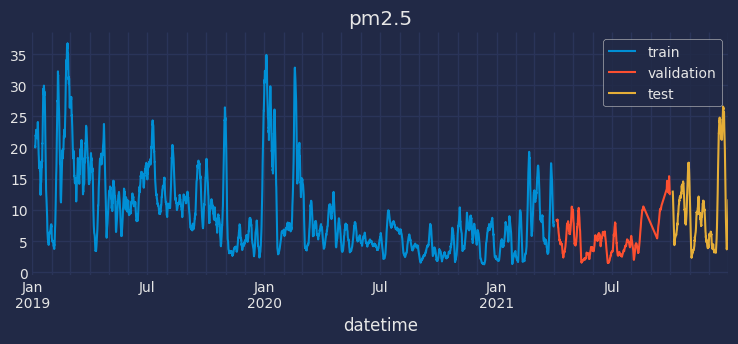

In [28]:
# Plotting one feature
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(8, 3))
air_quality_train["pm2.5"].rolling(100).mean().plot(ax=ax, label="train")
air_quality_val["pm2.5"].rolling(100).mean().plot(ax=ax, label="validation")
air_quality_test["pm2.5"].rolling(100).mean().plot(ax=ax, label="test")
ax.set_title("pm2.5")
ax.legend();

## Types of problems in time series modeling

### 1:1 Single-Step Forecasting - Predict one step ahead of a single series using the same series as predictor.


This type of problem involves modeling a time series using only its own past. It is a typical autoregressive problem.

Although tensorflow-keras facilitates the process of creating *deep learning* architectures, it is not always trivial to determine the Xtrain and Ytrain dimensions requiered to run an LSTM model. The dimensions depend on how many time series are being modeled, how many of them are are used as predictors, and the length of the prediction horizon.


<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The `create_and_compile_model` function is designed to facilitate the creation of the Tensorflow model. Advanced users can create their own architectures and pass them to the skforecast RNN Forecaster. Input and output dimensions must match the use case to which the model will be applied. the Annex at the end of the document for more details.

</div>

In [29]:
# Create model
# ==============================================================================
series = ["o3"]  # Series used as predictors
levels = ["o3"]  # Target series to predict
lags = 32  # Past time steps to be used to predict the target
steps = 1  # Future time steps to be predicted

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100,100,100,100],
    dense_units=[64,32,16,8],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.7.0
Using backend: torch
torch version: 2.5.1+cu124


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,217 (1.11 MB)

 Trainable params: 291,217 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Forecaster Definition
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 3,  # Number of epochs to train the model.
        "batch_size": 2048,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)    

forecaster

/home/ec2-user/git-repos/skforecast/skforecast/deep_learning/_forecaster_rnn.py:231: UserWarning: Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.
  warnings.warn(
/home/ec2-user/git-repos/skforecast/skforecast/deep_learning/_forecaster_rnn.py:266: UserWarning: `steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.
  warnings.warn(


ForecasterRnn 
Regressor: <Functional name=functional_1, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional_1', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_1'}, 'registered_name': None, 'name': 'input_layer_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': True, 'return_state': False, 'go_backwards': False, 's

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>


The output warning indicates that the number of lags has been inferred from the model architecture. In this case, the model has an LSTM layer with 32 neurons, so the number of lags is 32. If a different number of lags is desired, the `lags` argument can be specified in the `create_and_compile_model` function.
To omit the warning, set `lags=lags` and `steps=steps` arguments can be specified in the initialization of the `ForecasterRnn`.

</div>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The **skforecast** library is fully compatible with GPUs. See the **Running in GPU** section below in this document for more information.
</div>

In [33]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Using device: cuda
Epoch 1/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - loss: 64.7907 - val_loss: 0.0984
Epoch 2/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 0.0972 - val_loss: 0.1732
Epoch 3/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 3.9533 - val_loss: 0.2000


Overfitting can be tracked by moniting the loss function on the validation set. Metrics are automatically stored in the `history` attribute of the `ForecasterRnn` object. The method `plot_history` can be used to visualize the training and validation loss.

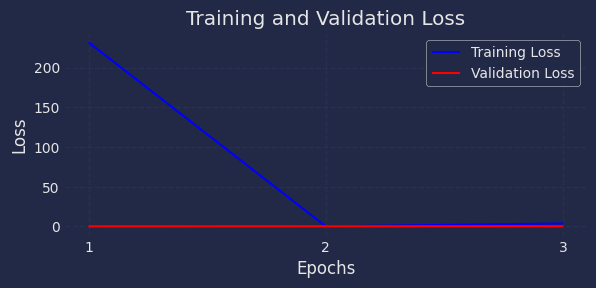

In [34]:
# Track training and overfitting
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
forecaster.plot_history(ax=ax)

In [35]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()
predictions

,o3
2021-04-01,10.231219


In [36]:
# Backtesting with test data
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data.loc[:end_validation, :]),  # Training + Validation Data
         refit              = False
     )

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data,
    cv=cv,
    levels=forecaster.levels,
    metric="mean_absolute_error",
    verbose=False  # Set to True to print detailed information
)

Using device: cuda
Epoch 1/3
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - loss: 0.1540 - val_loss: 0.1461
Epoch 2/3
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - loss: 0.0806 - val_loss: 0.0401
Epoch 3/3
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - loss: 0.0606 - val_loss: 0.0707


100%|██████████| 2208/2208 [04:01<00:00,  9.13it/s]


In [37]:
# Backtesting predictions
# ==============================================================================
predictions

,o3
2021-10-01 00:00:00,38.169514
2021-10-01 01:00:00,38.174603
2021-10-01 02:00:00,38.179237
2021-10-01 03:00:00,38.183372
2021-10-01 04:00:00,38.186924
...,...
2021-12-31 19:00:00,37.956234
2021-12-31 20:00:00,37.959518
2021-12-31 21:00:00,37.962673
2021-12-31 22:00:00,37.965408


In [38]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Serie mean: 54.52
Relative error (mae): 32.13 %


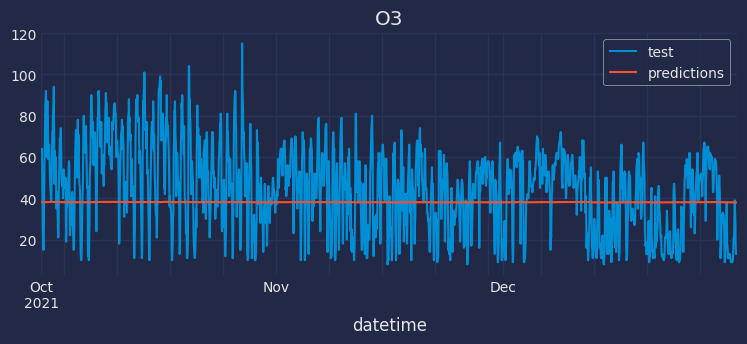

In [39]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data_test["o3"].plot(ax=ax, label="test")
predictions["o3"].plot(ax=ax, label="predictions")
ax.set_title("O3")
ax.legend();

### 1:1 Multiple-Step Forecasting - Predict a single series using the same series as predictor. Multiple steps ahead.



The next case is similar to the previous one, but now the goal is to predict multiple future values. In this scenario multiple future steps of a single time series are modeled using only its past values.

A similar architecture to the previous one will be used, but with a greater number of neurons in the LSTM layer and in the first dense layer. This will allow the model to have greater flexibility to predict the time series.

In [40]:
# Model creation
# ==============================================================================
series = ["o3"]  # Series used as predictors
levels = ["o3"]  # Target series to predict
lags = 32  # Past time steps to be used to predict the target
steps = 5  # Future time steps to be predicted

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=50,
    dense_units=32,
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.7.0
Using backend: torch
torch version: 2.5.1+cu124


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 5, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,197 (47.64 KB)

 Trainable params: 12,197 (47.64 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 3,  # Number of epochs to train the model.
        "batch_size": 1024,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)    

forecaster

/home/ec2-user/git-repos/skforecast/skforecast/deep_learning/_forecaster_rnn.py:231: UserWarning: Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.
  warnings.warn(
/home/ec2-user/git-repos/skforecast/skforecast/deep_learning/_forecaster_rnn.py:266: UserWarning: `steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.
  warnings.warn(


ForecasterRnn 
Regressor: <Functional name=functional_2, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional_2', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_2'}, 'registered_name': None, 'name': 'input_layer_2', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state': False, 'go_backwards': 

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The `fit_kwargs` parameter allows the user to set any Tensorflow-based configuration in the model. In the example, 10 training epochs are defined with a batch size of 32. An `EarlyStopping` callback is configured to stop training when the validation loss stops decreasing for 5 epochs (`patience=5`). Other callbacks can also be configured, such as `ModelCheckpoint` to save the model at each epoch, or even Tensorboard to visualize the training and validation loss in real time.

</div>

In [42]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Using device: cuda
Epoch 1/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.1054 - val_loss: 0.0304
Epoch 2/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0328 - val_loss: 0.0269
Epoch 3/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0277 - val_loss: 0.0279


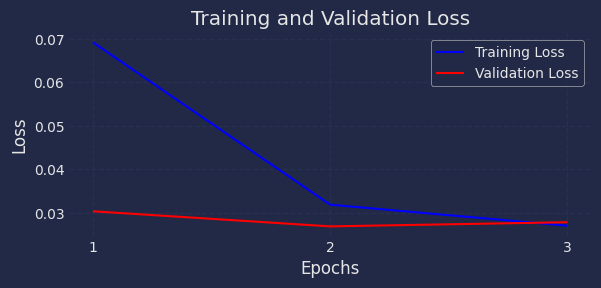

In [43]:
# Train and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
forecaster.plot_history(ax=ax)

In [44]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,o3
2021-04-01 00:00:00,63.629314
2021-04-01 01:00:00,59.237988
2021-04-01 02:00:00,58.990860
2021-04-01 03:00:00,61.347385
2021-04-01 04:00:00,59.542408


In [45]:
# Specific step predictions
# ==============================================================================
predictions = forecaster.predict(steps=[1, 3])
predictions

,o3
2021-04-01 00:00:00,63.629314
2021-04-01 02:00:00,58.990860


In [46]:
# Backtesting 
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data.loc[:end_validation, :]),  # Training + Validation Data
         refit              = False
     )

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data,
    cv=cv,
    levels=forecaster.levels,
    metric="mean_absolute_error",
    verbose=False
)

Using device: cuda
Epoch 1/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0255 - val_loss: 0.0243
Epoch 2/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0232 - val_loss: 0.0224
Epoch 3/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0197 - val_loss: 0.0144


100%|██████████| 442/442 [00:15<00:00, 28.63it/s]


In [47]:
# Backtesting predictions
# ==============================================================================
predictions

,o3
2021-10-01 00:00:00,50.923553
2021-10-01 01:00:00,47.460304
2021-10-01 02:00:00,47.833038
2021-10-01 03:00:00,48.654507
2021-10-01 04:00:00,46.162537
...,...
2021-12-31 19:00:00,33.516888
2021-12-31 20:00:00,32.878162
2021-12-31 21:00:00,17.542944
2021-12-31 22:00:00,18.012362


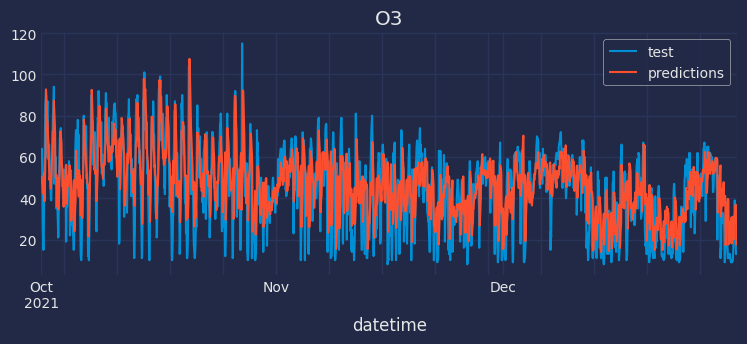

In [48]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data_test["o3"].plot(ax=ax, label="test")
predictions["o3"].plot(ax=ax, label="predictions")
ax.set_title("O3")
ax.legend();

In [49]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,o3,12.186881


In [50]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Serie mean: 54.52
Relative error (mae): 22.35 %


### N:1 Multiple-Step Forecasting - Predict one series using multiple series as predictors.

In this case, a single series will be predicted, but using multiple time series as predictors. Now, the past values of multiple time series will influence the prediction of a single time series.

In [51]:
# Model creation
# ==============================================================================
# Time series used in the training. Now, it is multiseries
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'so2'] 
levels = ["o3"] 
lags = 32 
steps = 5 

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.7.0
Using backend: torch
torch version: 2.5.1+cu124


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32, 100)        │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 5, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,109 (312.93 KB)

 Trainable params: 80,109 (312.93 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Forecaster creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    steps=steps,
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 4,  
        "batch_size": 1024,  
        "series_val": data_val,
    },
)
forecaster

ForecasterRnn 
Regressor: <Functional name=functional_3, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional_3', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 10), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_3'}, 'registered_name': None, 'name': 'input_layer_3', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': True, 'return_state': False, 'go_backwards': 

In [53]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Using device: cuda
Epoch 1/4
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 62171.0430 - val_loss: 0.0362
Epoch 2/4
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0423 - val_loss: 0.0417
Epoch 3/4
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0302 - val_loss: 0.0389
Epoch 4/4
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0278 - val_loss: 0.0331


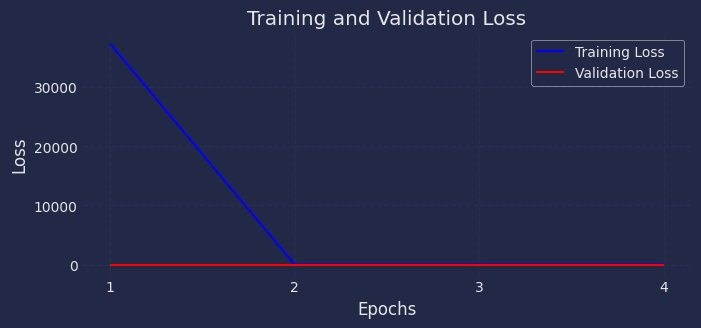

In [54]:
# Trainig and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
forecaster.plot_history(ax=ax)

In [55]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,o3
2021-04-01 00:00:00,33.955570
2021-04-01 01:00:00,34.747593
2021-04-01 02:00:00,36.764946
2021-04-01 03:00:00,37.375992
2021-04-01 04:00:00,36.329498


In [56]:
# Backtesting with test data
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data.loc[:end_validation, :]),  # Training + Validation Data
         refit              = False
     )

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data,
    cv=cv,
    levels=forecaster.levels,
    metric="mean_absolute_error",
    verbose=False
)

Using device: cuda
Epoch 1/4
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0269 - val_loss: 0.0271
Epoch 2/4
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0231 - val_loss: 0.0232
Epoch 3/4
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0173 - val_loss: 0.0192
Epoch 4/4
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0158 - val_loss: 0.0161


100%|██████████| 442/442 [00:35<00:00, 12.48it/s]


In [57]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,o3,13.57105


In [58]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Serie mean: 54.52
Relative error (mae): 24.89 %


In [59]:
# Backtesting predictions
# ==============================================================================
predictions

,o3
2021-10-01 00:00:00,51.959362
2021-10-01 01:00:00,52.959923
2021-10-01 02:00:00,51.435425
2021-10-01 03:00:00,51.297440
2021-10-01 04:00:00,53.002201
...,...
2021-12-31 19:00:00,14.822255
2021-12-31 20:00:00,9.298287
2021-12-31 21:00:00,21.684856
2021-12-31 22:00:00,25.711485


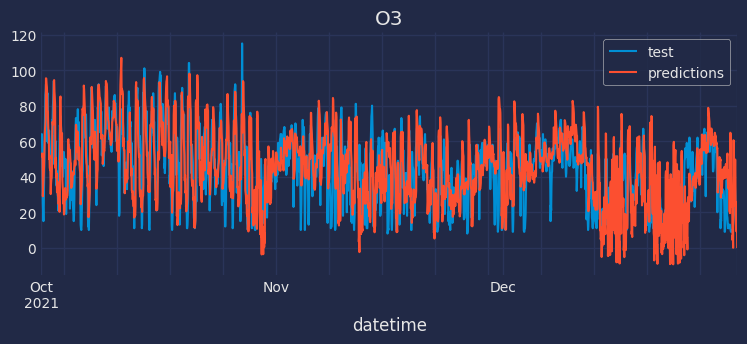

In [60]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data_test["o3"].plot(ax=ax, label="test")
predictions["o3"].plot(ax=ax, label="predictions")
ax.set_title("O3")
ax.legend();


### N:M Multiple-Step Forecasting - Multiple time series with multiple outputs

This is a more complex scenario in which multiple time series are predicted using multiple time series as predictors. It is therefore a scenario in which multiple series are modeled simultaneously using a single model. This has special application in many real scenarios, such as the prediction of stock values for several companies based on the stock history, the price of energy and commodities. Or the case of forecasting multiple products in an online store, based on the sales of other products, the price of the products, etc.

In [61]:
# Model creation
# ==============================================================================
# Now, we have multiple series and multiple targets
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'so2'] 
levels = ['pm2.5', 'co', 'no', "o3"]  # Features to predict. It can be all the series or less
lags = 32 
steps = 5 

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.7.0
Using backend: torch
torch version: 2.5.1+cu124


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32, 100)        │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 5, 4)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,604 (314.86 KB)

 Trainable params: 80,604 (314.86 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Forecaster creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    steps=steps,
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 10, 
        "batch_size": 1024, 
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=3)
        ],  
        "series_val": data_val,
    },
)
forecaster

ForecasterRnn 
Regressor: <Functional name=functional_4, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['pm2.5', 'co', 'no', 'o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional_4', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 10), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_4'}, 'registered_name': None, 'name': 'input_layer_4', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': True, 'return_state': F

In [63]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Using device: cuda
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0225 - val_loss: 0.0181
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0103 - val_loss: 0.0173
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0086 - val_loss: 0.0137
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0069 - val_loss: 0.0116
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0058 - val_loss: 0.0112
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0052 - val_loss: 0.0102
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0049 - val_loss: 0.0097
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0045 - val_loss: 0.0098
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0045 - val_loss: 0.0093
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0041 - val_loss: 0.0091


The prediction can also be made for specific `steps`, as long as they are within the prediction horizon defined in the model.

In [64]:
# Specific step predictions
# ==============================================================================
forecaster.predict(steps=[1, 5], levels="o3")

,o3
2021-04-01 00:00:00,44.873596
2021-04-01 04:00:00,26.408749


In [65]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,pm2.5,co,no,o3
2021-04-01 00:00:00,13.898178,0.133584,3.168530,44.873596
2021-04-01 01:00:00,14.257277,0.122665,2.154568,40.487301
2021-04-01 02:00:00,14.798995,0.117694,2.979087,35.340221
2021-04-01 03:00:00,14.365874,0.134463,3.028424,27.659452
2021-04-01 04:00:00,14.765499,0.116621,2.774541,26.408749


In [66]:
# Backtesting with test data
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data.loc[:end_validation, :]),  # Training + Validation Data
         refit              = False
     )

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data,
    cv=cv,
    levels=forecaster.levels,
    metric="mean_absolute_error",
    verbose=False
)

Using device: cuda
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0039 - val_loss: 0.0085
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0038 - val_loss: 0.0085
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0038 - val_loss: 0.0083
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0036 - val_loss: 0.0083
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0036 - val_loss: 0.0081
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0035 - val_loss: 0.0075
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0035 - val_loss: 0.0069
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0034 - val_loss: 0.0071
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0033 - val_loss: 0.0072
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0033 - val_loss: 0.0067


100%|██████████| 442/442 [00:37<00:00, 11.81it/s]


In [67]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,pm2.5,3.315464
1,co,0.031304
2,no,2.767295
3,o3,12.339591
4,average,4.613414
5,weighted_average,4.613414
6,pooling,4.613414


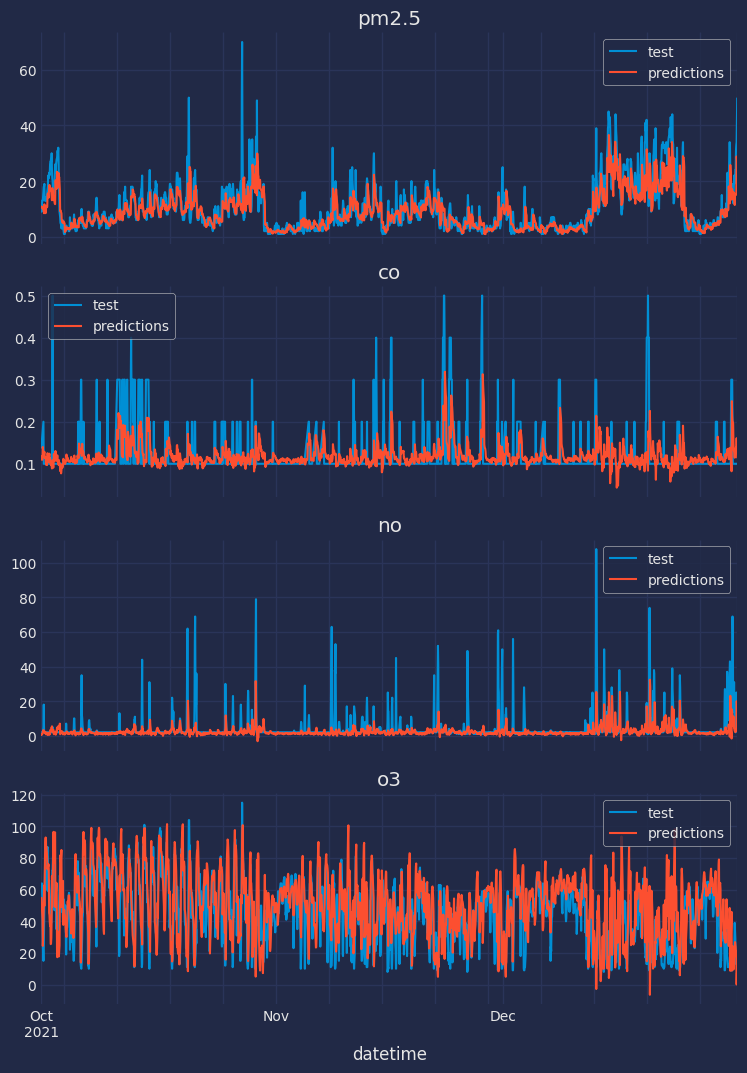

In [68]:
# Plot all the predicted variables as rows in the plot
# ==============================================================================
fig, ax = plt.subplots(len(levels), 1, figsize=(8, 3 * len(levels)), sharex=True)
for i, level in enumerate(levels):
    data_test[level].plot(ax=ax[i], label="test")
    predictions[level].plot(ax=ax[i], label="predictions")
    ax[i].set_title(level)
    ax[i].legend()

## Create and compile Tensorflow models

To improve the user experience and speed up the prototyping, development, and production process, skforecast has the `create_and_compile_model` function, with which, by indicating just a few arguments, the architecture is inferred and the model is created.

+ `series`: Time series to be used to train the model

+ `levels`: Time series to be predicted.
  
+ `lags`: Number of time steps to be used to predict the next value.

+ `steps`: Number of time steps to be predicted.

+ `recurrent_layer`: Type of recurrent layer to use. By default, an LSTM layer is used.
  
+ `recurrent_units`: Number of units in the recurrent layer. By default, 100 is used. If a list is passed, a recurrent layer will be created for each element in the list.

+ `dense_units`: Number of units in the dense layer. By default, 64 is used. If a list is passed, a dense layer will be created for each element in the list.
  
+ `optimizer`: Optimizer to use. By default, Adam with a learning rate of 0.01 is used.
  
+ `loss`: Loss function to use. By default, Mean Squared Error is used.


<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The following examples use <code>recurrent_layer="LSTM"</code> but it is also possible to use <code>"RNN"</code> layers.

</div>

In [69]:
# Create model
# ==============================================================================
series = ["o3"]  # Series used as predictors
levels = ["o3"]  # Target series to predict
lags = 32        # Past time steps to be used to predict the target
steps = 1        # Future time steps to be predicted

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=4,
    dense_units=16,
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.7.0
Using backend: torch
torch version: 2.5.1+cu124


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 4)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 1, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

In this case, a simple LSTM network is used, with a single recurrent layer with 4 neurons and a hidden dense layer with 16 neurons. The following table shows a detailed description of each layer:


| Layer                        | Type            | Output Shape      | Parameters  | Description                                                                                         |
|-----------------------------|-----------------|-------------------|-------------|-----------------------------------------------------------------------------------------------------|
| Input Layer (InputLayer)    | `InputLayer`    | `(None, 32, 1)`   | 0           | This is the input layer of the model. It receives sequences of length 32, corresponding to the number of lags with a dimension at each time step. |
| LSTM Layer (Long Short-Term Memory)| `LSTM`       | `(None, 4)`       | 96          | The LSTM layer is a long and short-term memory layer that processes the input sequence. It has 4 LSTM units and connects to the next layer.  |
| First Dense Layer (Dense)   | `Dense`         | `(None, 16)`      | 80          | This is a fully connected layer with 16 units and uses a default activation function (relu) in the provided architecture.     |
| Second Dense Layer (Dense)  | `Dense`         | `(None, 1)`       | 17          | Another fully connected dense layer, this time with a single output unit. It also uses a default activation function.          |
| Reshape Layer (Reshape)     | `Reshape`       | `(None, 1, 1)`    | 0           | This layer reshapes the output of the previous dense layer to have a specific shape `(None, 1, 1)`. This layer is not strictly necessary, but is included to make the module generalizable to other multi-output forecasting problems. The dimension of this output layer is `(None, steps_to_predict_future, series_to_predict)`. In this case, `steps=1 and levels="o3"`, so the dimension is `(None, 1, 1)`  |
| Total Parameters and Trainable | -           | -                 | 193         | Total Parameters: 193, Trainable Parameters: 193, Non-Trainable Parameters: 0               |


More complex models can be created including:

* Multiple series to be modeled (levels)
* Multiple series to be used as predictors (series)
* Multiple steps to be predicted (steps)
* Multiple lags to be used as predictors (lags)
* Multiple recurrent layers (recurrent_units)
* Multiple dense layers (dense_units)

In [70]:
# Model creation
# ==============================================================================
# Now, we have multiple series and multiple targets
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'so2'] 
levels = ['pm2.5', 'co', 'no', "o3"]  # Features to predict. It can be all the series or less
lags = 32 
steps = 5 

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.7.0
Using backend: torch
torch version: 2.5.1+cu124


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 32, 100)        │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 5, 4)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,604 (314.86 KB)

 Trainable params: 80,604 (314.86 KB)

 Non-trainable params: 0 (0.00 B)

## Running on GPU

The **skforecast** library is fully compatible with GPUs, enabling accelerated computation during model training when the appropriate hardware and software configurations are in place. If a compatible GPU is detected and properly configured, **skforecast** will automatically utilize the GPU to speed up the training process, especially for large and complex models.

### GPU Performance and Batch Size Considerations
The performance gains from using a GPU are most noticeable when training with larger batch sizes. This is because GPUs are optimized for parallel processing, and larger batches allow the GPU to process more data simultaneously. However, if the batch size is too small, the benefits of using the GPU over the CPU may be minimal.

- **Optimal Batch Size**: For most models, increasing the batch size to values such as **64**, **128**, or **1024** can yield significant performance improvements. Training with small batch sizes may result in the GPU performing similarly to the CPU.
- **Example Performance Gain**: For larger models and batches, you may experience substantial improvements in training times. For instance, on an **NVIDIA T4 GPU**, training time was reduced from **1m 20s** on the CPU to just **6 seconds** on the GPU when using larger batches.

### Setting Up and Using the GPU
To run models on the GPU using **skforecast**, ensure the following:
1. The GPU is properly installed and configured on your machine.
2. The necessary dependencies, including PyTorch with CUDA support, are installed.
3. The GPU is detected correctly by PyTorch using `torch.cuda.is_available()`.

Once these configurations are in place, no further modifications are needed to use the GPU with **skforecast**. The library will automatically leverage GPU resources when available, providing faster training times.

---

### Example Code: Model Creation and Training

```python
# Create model
# ==============================================================================
series = ["o3"]  # Series used as predictors
levels = ["o3"]  # Target series to predict
lags = 32  # Past time steps to be used to predict the target
steps = 1  # Future time steps to be predicted

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 100, 100, 100],
    dense_units=[64, 32, 16, 8],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

# Forecaster Definition
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 3,  # Number of epochs to train the model.
        "batch_size": 512,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)    

# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)
```

### Conclusion
Once your GPU is properly configured, **skforecast** will automatically detect it and accelerate training, reducing computation time significantly for larger models and datasets. The key to maximizing GPU performance lies in selecting an appropriate batch size. Larger batch sizes allow the GPU to utilize its parallel processing power effectively, leading to faster training times.

## Get training and test matrices

In [71]:
# Model creation
# ==============================================================================
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'so2'] 
levels = ['pm2.5', 'co', 'no', "o3"]  # Features to predict. It can be all the series or less
lags = 10 
steps = 5 

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)

forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    steps=steps,
    lags=lags,
)
forecaster

keras version: 3.7.0
Using backend: torch
torch version: 2.5.1+cu124


ForecasterRnn 
Regressor: <Functional name=functional_7, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for series: MinMaxScaler() 
Window size: 10 
Target series, levels: ['pm2.5', 'co', 'no', 'o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional_7', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 10, 10), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_7'}, 'registered_name': None, 'name': 'input_layer_7', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_16', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'z

In [72]:
forecaster.create_train_X_y(data_train)[2]["X_train"][2]

['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'so2']

The RNN Forecaster can also be used to generate the X_train and y_train matrices that will be used to train the model. The `create_train_X_y` method allows the user to obtain the training and test matrices that will be used to train the model. The method return 3 elements: X_train, y_train, and dimension_information. The X_train matrix has dimensions `(n_samples, n_lags, n_series)`, while the y_train matrix has dimensions `(n_samples, n_steps, n_levels)`.



In [73]:
X_train, y_train, dimension_info = forecaster.create_train_X_y(data_train)

In [74]:
X_train.shape, y_train.shape

((19690, 10, 10), (19690, 5, 4))

The dimension_information dictionary contains the information of each dimension value for both X_train and y_train.

In [75]:
dimension_info["X_train"][0][:10]

[Timestamp('2019-01-01 10:00:00'),
 Timestamp('2019-01-01 11:00:00'),
 Timestamp('2019-01-01 12:00:00'),
 Timestamp('2019-01-01 13:00:00'),
 Timestamp('2019-01-01 14:00:00'),
 Timestamp('2019-01-01 15:00:00'),
 Timestamp('2019-01-01 16:00:00'),
 Timestamp('2019-01-01 17:00:00'),
 Timestamp('2019-01-01 18:00:00'),
 Timestamp('2019-01-01 19:00:00')]

In [76]:
dimension_info["X_train"][1]

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10']

In [77]:
dimension_info["X_train"][2]

['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'so2']

In [78]:
dimension_info["y_train"][0][:10]

[Timestamp('2019-01-01 10:00:00'),
 Timestamp('2019-01-01 11:00:00'),
 Timestamp('2019-01-01 12:00:00'),
 Timestamp('2019-01-01 13:00:00'),
 Timestamp('2019-01-01 14:00:00'),
 Timestamp('2019-01-01 15:00:00'),
 Timestamp('2019-01-01 16:00:00'),
 Timestamp('2019-01-01 17:00:00'),
 Timestamp('2019-01-01 18:00:00'),
 Timestamp('2019-01-01 19:00:00')]

In [79]:
dimension_info["y_train"][1]

['step_1', 'step_2', 'step_3', 'step_4', 'step_5']

In [80]:
dimension_info["y_train"][2]

['pm2.5', 'co', 'no', 'o3']